In [ ]:
https://slides.com/edsharp/gis_energy_data_anaytics2

In [1]:
import pandas
import matplotlib.pyplot as plt

# Load and filter data

Concentration data https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory--laei--2016, see  concentrations excel files

https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2016/20fd5087-ee4e-4037-8b3a-61271f31348a/LAEI_2016_Concentrations_Data_Excel.zip

In [2]:
no2 = pandas.read_csv('../data/CSV/LAEI2016_2016_NO2.csv')
pm25 = pandas.read_csv('../data/CSV/LAEI2016_2016_PM25.csv')

Educational establishment data, from https://get-information-schools.service.gov.uk/Downloads, see all establishment data

https://ea-edubase-api-prod.azurewebsites.net/edubase/downloads/public/edubasealldata20200310.csv

In [4]:
# edubase appears to use non ut8 encoding
edub = pandas.read_csv('../data/CSV/edubasealldata20200310.csv', encoding = "ISO-8859-1", low_memory = False)

32 London borough from this list https://en.wikipedia.org/wiki/List_of_London_boroughs, this can be used to filter edubase to extract estvblishments in London

In [5]:
bors = ['Barking and Dagenham', 'Barnet' ,'Bexley','Brent', 'Bromley','Camden','Croydon','Ealing','Enfield','Greenwich','Hackney', 'Hammersmith and Fulham','Haringey','Harrow','Havering','Hillingdon','Hounslow',
 'Islington', 'Kensington and Chelsea','Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets', 'Waltham Forest','Wandsworth','Westminster']

There are several ways of filtering edubase to show only nurseries, the EstablishmentTypeGroup (name) field has a "local authority nursery school" option, but there are only 95 of these in London, PhaseOfEducation (name) has a "nursery" option these are the same as the local authority option.  A better filter are establishments which have nursery classes, where there are 2316, this doesn't include all of the nursery lablled establishment, so both filters are used

In [6]:
print(len(edub.loc[edub["LA (name)"].isin(bors)]), "establishments in the London boroughs")

5626 establishments in the London boroughs


In [7]:
print(len(edub.loc[(edub["LA (name)"].isin(bors) & (edub["PhaseOfEducation (name)"] == "Nursery"))]), "establishments in the London boroughs")

95 establishments in the London boroughs


In [8]:
print(len(edub.loc[(edub["LA (name)"].isin(bors) & (edub["TypeOfEstablishment (name)"] == "Local authority nursery school"))]), "establishments in the London boroughs")

95 establishments in the London boroughs


In [9]:
print(len(edub.loc[(edub["LA (name)"].isin(bors) & (edub["NurseryProvision (name)"] == "Has Nursery Classes"))]), "establishments in the London boroughs")

2340 establishments in the London boroughs


In [10]:
print(len(edub.loc[(edub["LA (name)"].isin(bors) & (edub["NurseryProvision (name)"] == "Has Nursery Classes")  & (edub["TypeOfEstablishment (name)"] == "Local authority nursery school"))]), "establishments in the London boroughs")

81 establishments in the London boroughs


In [11]:
print(len(edub.loc[(edub["LA (name)"].isin(bors) & (edub["NurseryProvision (name)"] == "Has Nursery Classes")  & (edub["PhaseOfEducation (name)"] == "Nursery"))]), "establishments in the London boroughs")

81 establishments in the London boroughs


In [12]:
nurseries = edub.loc[(edub["LA (name)"].isin(bors) & (edub["NurseryProvision (name)"] == "Has Nursery Classes"))]

In [13]:
nurseries =nurseries.append(edub.loc[(edub["LA (name)"].isin(bors) & (edub["TypeOfEstablishment (name)"] == "Local authority nursery school"))])

In [14]:
nurseries = nurseries.drop_duplicates('URN')

In [15]:
# exclude those with no spatial reference

In [16]:
nurseries = nurseries.loc[nurseries.Easting !=0]

In [17]:
nurseries.to_csv("../data/london_nurseries_edubase_2019.csv")

# Test data

Quick check to verfiy that the coordinate systems are the same, e.g. do the coordinates overlap, looks a little off

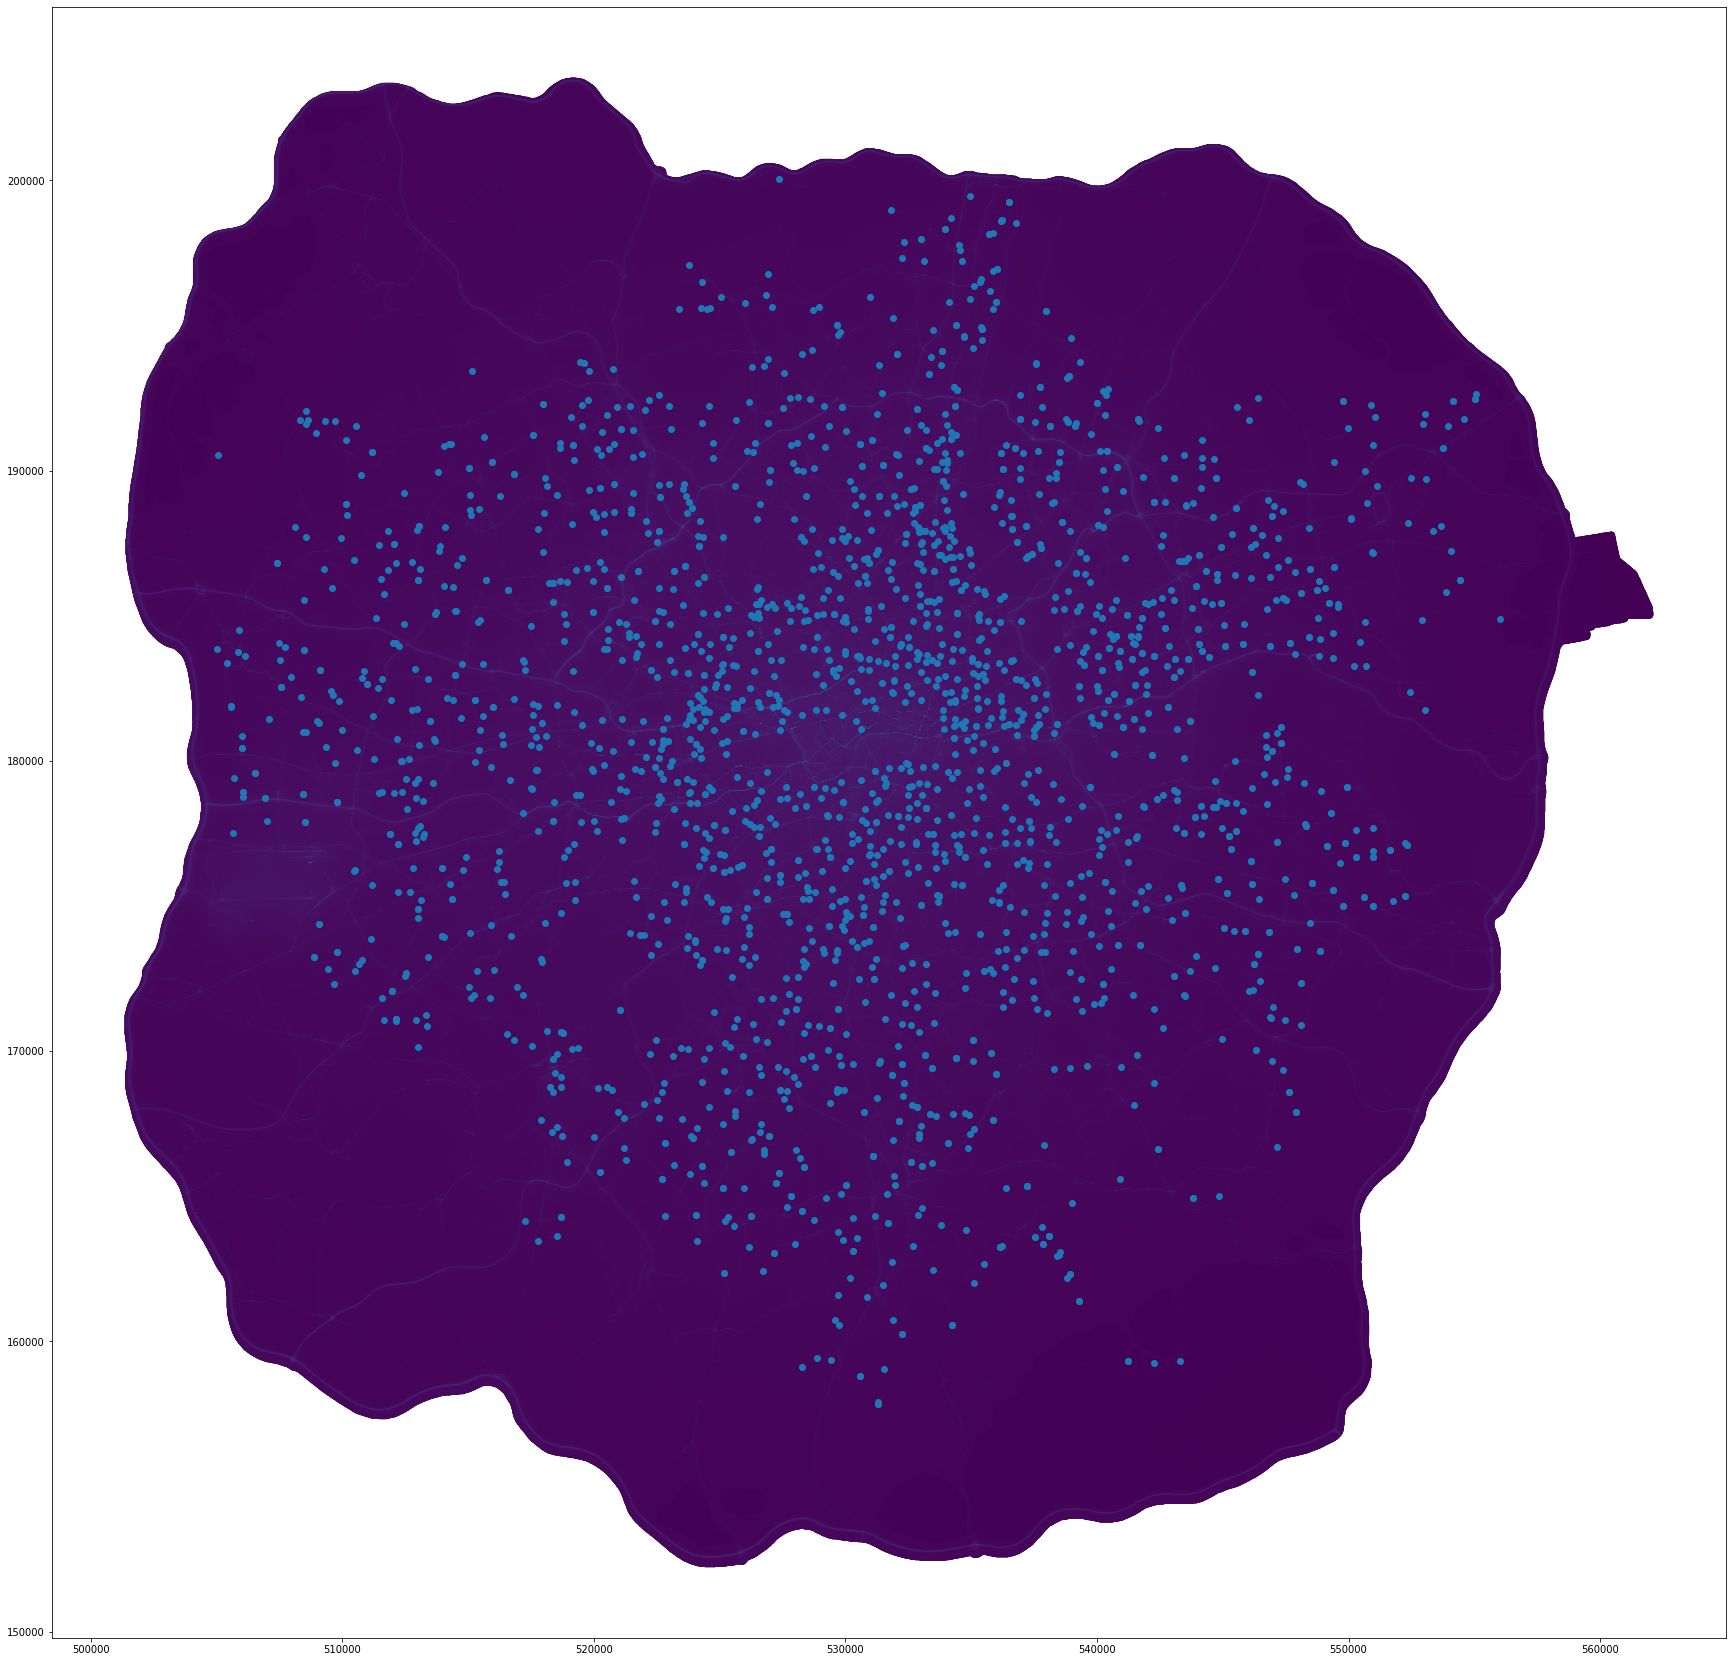

In [22]:
plt.figure(figsize=(30,30))
plt.scatter(no2.x.values, no2.y.values,c = no2.conc.values )
plt.scatter(nurseries.Easting.values, nurseries.Northing.values)
plt.savefig('../data/test_map.png')

# Use KD nearest neighbours from scipy to calculate the closest points, as a position in a list of points

In [19]:
from scipy.spatial import KDTree
from shapely.geometry import Point

In [20]:
nursery_pts = nurseries[["Easting", "Northing"]].values

In [ ]:
no2_tree = KDTree(no2[['x','y']].values)

In [ ]:
nearest_no2 = no2_trees.query(nursery_pts)

In [ ]:
pm25_tree = KDTree(pm25[['x','y']].values)

In [ ]:
nearest_pm25 = pm25_tree.query(nursery_pts)

# Extract the point data and append to the nursery df

In [ ]:
no2_x = []
no2_y = []
no2_concs = []
for i in nearest_no2[1]:
    no2_x.append(no2.loc[i]["x"])
    no2_y.append(no2.loc[i]["y"])
    no2_concs.append(no2.loc[i]["conc"])
nurseries["no2_x"] = no2_x
nurseries["no2_y"] = no2_y
nurseries["no2_µg/m3"] = no2_concs

In [ ]:
pm_x = []
pm_y = []
pm_concs =[]
 
for i in nearest_pm25[1]:
    pm_x.append(pm25.loc[i]["x"])
    pm_y.append(pm25.loc[i]["y"])
    pm_concs.append(pm25.loc[i]["conc"])
nurseries["pm_x"] = pm_x
nurseries["pm_y"] = pm_y
nurseries["pm25_µg/m3"] = pm_concs

# Test that the difference is <=10m

In [ ]:
max(nurseries["pm_x"] - nurseries["Easting"])

In [ ]:
max(nurseries["pm_y"] - nurseries["Northing"])

In [ ]:
max(nurseries["no2_y"] - nurseries["Northing"])

In [ ]:
max(nurseries["no2_x"] - nurseries["Easting"])

In [ ]:
nurseries.to_csv("../data/london_nurseries_edubase_2019_with_concs.csv")

# Do a couple of visual checks to make sure it is correctly projected

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
ax.scatter(nurseries.Easting.values[0:-1], nurseries.Northing.values[0:-1])

In [ ]:
nurseries = nurseries[np.isfinite(nurseries['Easting'])]
nurseries = nurseries[np.isfinite(nurseries['Northing'])]
fig, ax = plt.subplots(figsize =(30,30))
ax.scatter(nurseries.Easting.values, nurseries.Northing.values)
 
for i, txt in enumerate(nurseries['EstablishmentName'].values):
    ax.annotate(txt, (nurseries.Easting.values[i], nurseries.Northing.values[i]),clip_on=True)
ax.set_xlim(xmin = min(nurseries.Easting.values), xmax = max(nurseries.Easting.values))
ax.set_ylim(ymin = min(nurseries.Northing.values), ymax = max(nurseries.Northing.values))


In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(no2.x.values, no2.y.values,c = no2.conc.values)
plt.scatter(nurseries.Easting.values, nurseries.Northing.values)